In [16]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows",45)
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    label = [["\n True Positive", "\n False Negative \n Type II Error"],
             ["\n False Positive \n Type I Error", "\n True Negative"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(pred_value):
    from sklearn.metrics import confusion_matrix
    actual_value = pd.read_pickle("dataset/kdd_test_2labels_y.pkl");

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, output_columns_2labels, normalize = True)

In [3]:
#kdd_diff_level_train = pd.read_pickle("dataset/kdd_diff_level_train.pkl")
#kdd_diff_level_test = pd.read_pickle("dataset/kdd_diff_level_test.pkl")
#output_columns_2labels = ['Normal','Attack']
output_columns_2labels = ['Attack','Normal']

In [4]:
def get_count(pred_value):
    difficulty = pd.DataFrame({"Actual":actual_value, "Predict":pred_value, "difficulty_level":kdd_diff_level_test})
    #difficulty = pd.concat(difficulty, pd.Data)
    difficulty['accuracy'] = None
    difficulty.ix[difficulty.Actual == difficulty.Predict, "accuracy"] = 'Correct'
    difficulty.ix[difficulty.Actual != difficulty.Predict, "accuracy"] = 'Incorrect'
    diff_group = difficulty.loc[:,["difficulty_level", "accuracy", "Predict"]].groupby(["difficulty_level", "accuracy"])
    total_correct = sum(difficulty.Actual == difficulty.Predict)
    total_records = difficulty.shape[0]
    total_incorrect = total_records - total_correct
    print("Total Records:{}".format(total_records))
    return diff_group.count()

In [35]:
def evaluate(pred_pkl, score_pkl):
    predictions = pd.read_pickle(pred_pkl)
    scores = pd.read_pickle(score_pkl)

    print(scores.sort_values("test_score", ascending=False))

    df_sorted = scores.sort_values("test_score", ascending=False).iloc[0,0:3]
    epoch = int(df_sorted['epoch'])
    n_o_f = int(df_sorted['no_of_features'])
    h_l = int(df_sorted['hidden_layers'])
    df_pred = predictions["{}_{}_{}".format(epoch,n_o_f,h_l)].round(2)
    Attack_index = actual_value == 0
    Normal_index = actual_value == 1

    df_pred[Attack_index].plot(kind='line', figsize=(20,5), title="Prediction of Attack")
    df_pred[Normal_index].plot(kind='line', figsize=(20,5), title="Prediction of Normal")
    

    pred_value = np.argmax(df_pred.values, axis=1)
    plot(pred_value)

# Evaluating Dense Network

    epoch  no_of_features  hidden_layers  train_score  test_score
3       5               4              2     0.704159    0.773155
0       5               2              2     0.660184    0.653522
9       5              16              2     0.470075    0.569242
5       5               4             10     0.464359    0.568444
14      5              32             10     0.458247    0.568267
10      5              16              6     0.463089    0.566137
11      5              16             10     0.462216    0.562899
12      5              32              2     0.462931    0.511089
6       5               8              2     0.514050    0.491350
7       5               8              6     0.537943    0.454933
1       5               2              6     0.536117    0.430758
2       5               2             10     0.536434    0.430758
4       5               4              6     0.529925    0.430758
8       5               8             10     0.527782    0.430758
13      5 

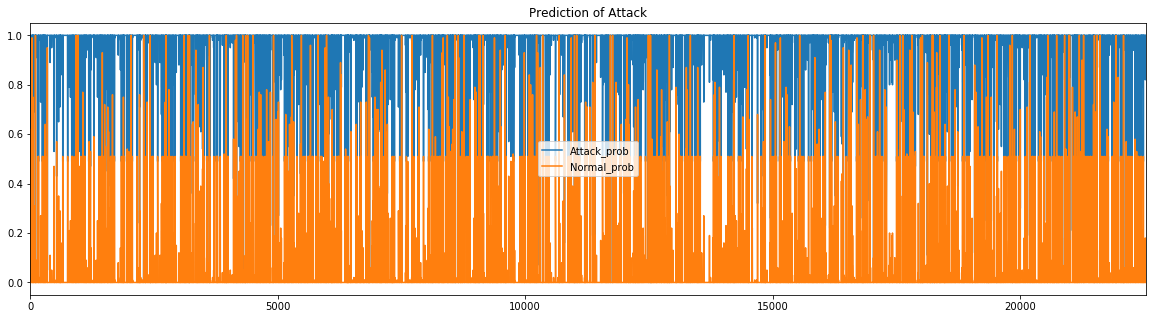

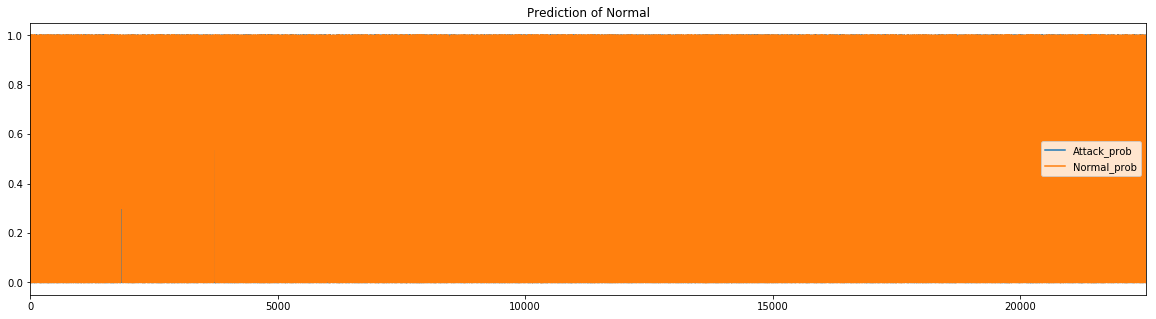

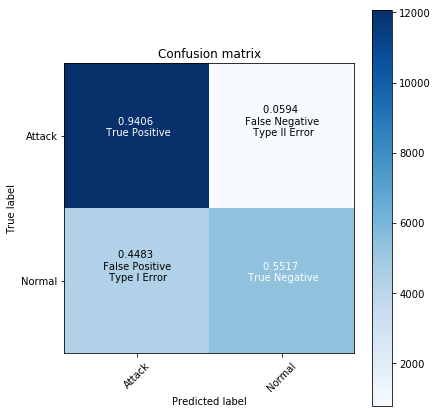

In [36]:
evaluate("dataset/keras_dense_nsl_kdd_predictions.pkl", "dataset/keras_dense_nsl_kdd_scores.pkl")

In [33]:
#get_count(pred_value)
#dense_only_predictions

# Evaluating VAE with Softmax - Trained Together

    epoch  no_of_features  hidden_layers  train_score  test_score
0       5               4              2     0.804737    0.807399
3       5              32              2     0.597631    0.598518
10      5              16              6     0.521336    0.514106
8       5               4              6     0.503371    0.505190
4       5               4              4     0.493302    0.497649
5       5               8              4     0.506388    0.494588
7       5              32              4     0.487669    0.493612
11      5              32              6     0.485406    0.490995
9       5               8              6     0.485495    0.485229
6       5              16              4     0.489265    0.479108
2       5              16              2     0.433330    0.436435
1       5               8              2     0.321194    0.324299
Normalized confusion matrix
[[ 0.8272  0.1728]
 [ 0.2029  0.7971]]


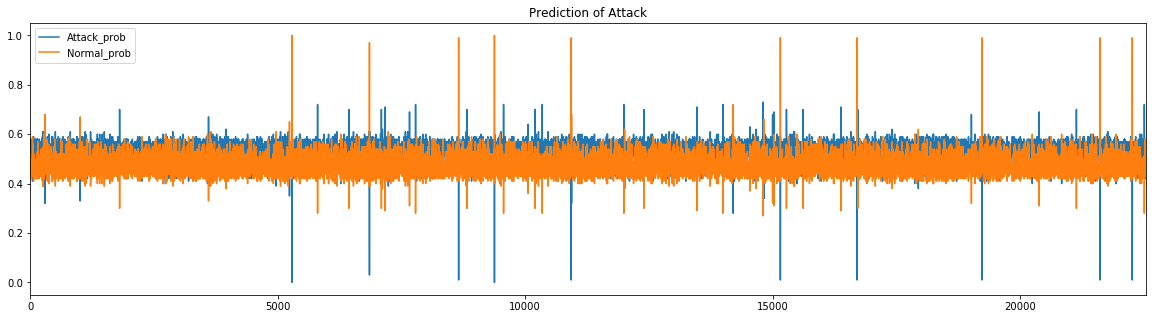

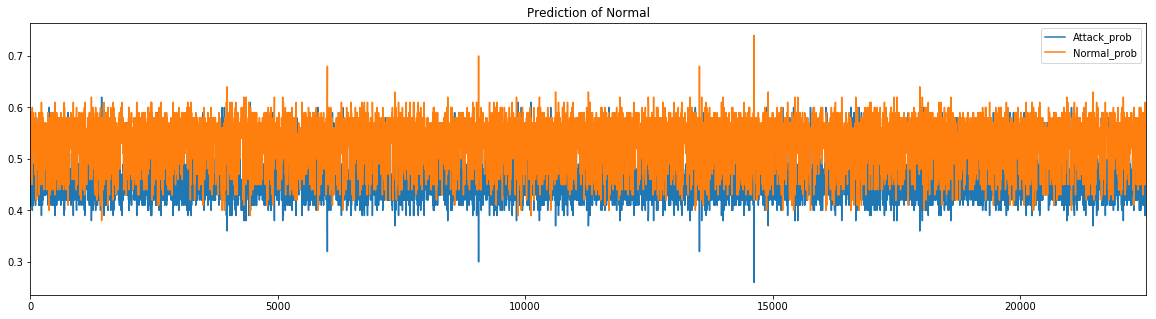

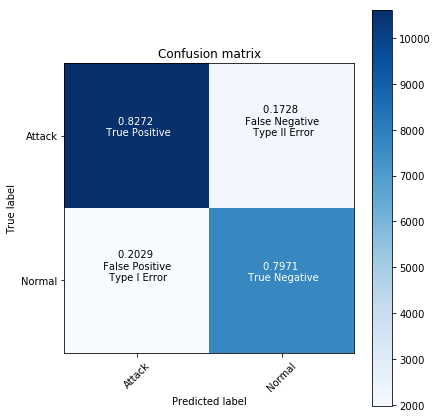

In [37]:
evaluate("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl",
         "dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")

In [38]:
evaluate("dataset/keras_vae_dense_trained_seperately_nsl_kdd_predictions.pkl",
         "dataset/keras_vae_dense_trained_seperately_nsl_kdd_scores.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/keras_vae_dense_trained_seperately_nsl_kdd_predictions.pkl'

   epoch  no_of_features  hidden_layers  train_score  test_score
6      5               4             10     0.726047    0.785309
2      5              32              2     0.534333    0.600027
0      5               4              2     0.706973    0.590002
7      5              16             10     0.467619    0.569242
8      5              32             10     0.467619    0.569242
3      5               4              6     0.569996    0.545600
4      5              16              6     0.536817    0.432754
5      5              32              6     0.532381    0.430758
1      5              16              2     0.323634    0.265082
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


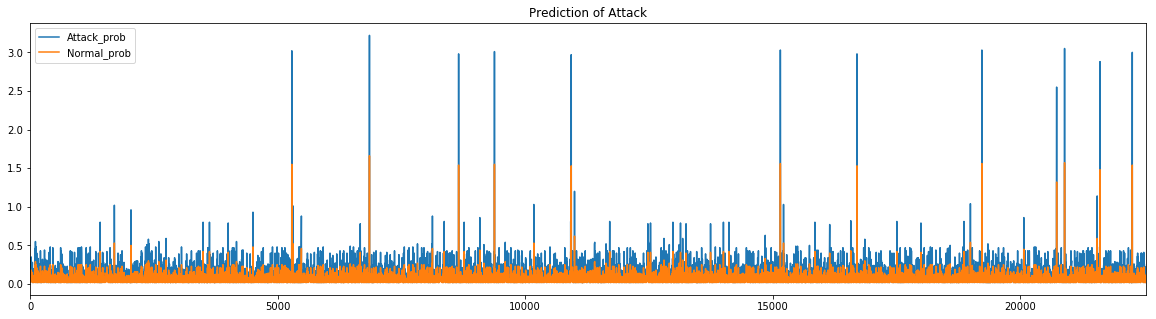

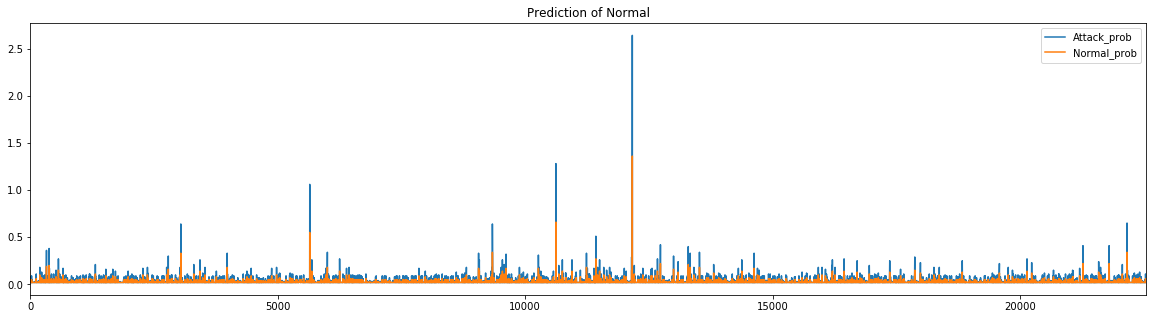

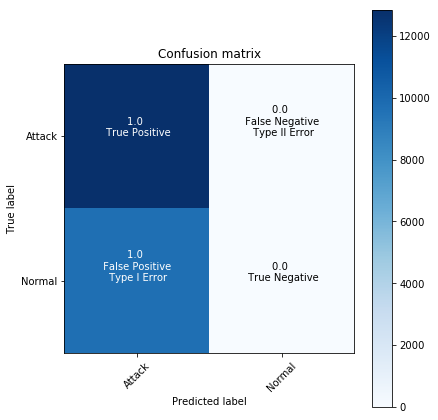

In [39]:
evaluate("dataset/keras_vae_with_label_nsl_kdd_predictions.pkl",
         "dataset/keras_vae_with_label_nsl_kdd_scores.pkl")